## Imports:

In [33]:
# #standard modules
# import pandas as pd
# import numpy as np
# import os
# import re
# #plots:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# import cartopy
# import cartopy.feature as cf
# import cartopy.crs as ccrs
# import seaborn as sns
# import folium
# from folium.plugins import HeatMap, HeatMapWithTime
# #data
# from netCDF4 import Dataset
# from pandas import datetime
# #IO
# import openpyxl
# #speedup
# from numba import jit
# #animations
# from celluloid import Camera # getting the camera
# from IPython.display import HTML # to show the animation in Jupyter

from functions import plot_merra_data, plot_ols_data, create_population_array,plot_gpw_data, create_population_weigth_array,daily_dust_country_regression,get_mse_data
# from functions import plot_main_dust
import os
import pickle
import numpy as np
import pandas as pd
from netCDF4 import Dataset

import matplotlib.pyplot as plt


from functions import process_merra_data

import statsmodels.api as sm

from numba import jit


import cmocean
import cmocean.cm as cmo


In [34]:
parent_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath("__file__")), os.pardir))

# 3. Empirical Strategy

## 3.3 Model Implementation

### Data

In [35]:
with open(parent_directory + '\\processed_data\\daily_novapr_indices', 'rb') as pickle_file:
        daily_novapr_indices = pickle.load(pickle_file)

with open(parent_directory + '\\processed_data\\daily_junsep_indices', 'rb') as pickle_file:
        daily_junsep_indices = pickle.load(pickle_file)


In [36]:
west_africa_longitudes = np.load(parent_directory + '\\processed_data\\west_africa_longitudes.npy')
west_africa_latitudes = np.load(parent_directory + '\\processed_data\\west_africa_latitudes.npy')

The first outcome I consider is country-level economic growth. To estimate the impacts of
dust storms on growth, I exploit random year-to-year variation in dust exposure in a fixed-
effects regression:

Country-level regression
$$g_{cy} = \sum_{j=0}^{L} [ \beta_{j}D_{cy-j} + \rho_{j}C_{cy-j} ] + \alpha_{0c} + \alpha_{1c}y + \alpha_{2c}y^{2} + \epsilon_{cy}$$
---
Where:
$$ D_{cy-j} = \text{measure of dust exposure}$$
$$ \text{instrumented by long-range transported dust, since variable is likely endogneous to eocnomic growth} $$
$$ C_{cy-j} = \text{climate, includes temperature and precipitation over the year} $$
$$ \beta_{0} = \text{captures the level effect of dust exposure on economic production} $$
$$ \Omega_{L} = \sum_{j=0}^{L} \beta_{j} = \text{captures the effect on GDP over L years} $$
$$ \epsilon_{cy} \text{ are allowed to be arbitrarily correlated across 5 years for the same country and across countries with centroids that are within 1000km of each other for the same year} $$

First specification, where dust is instrumented using a statistical relationship between source location dust and dust over the outcome location, dust in a given MERRA pixel on a given day is predicted using the following equation:

$$D_{pt} = \sum_{j=0}^{10} \gamma_{p,sj}D_{B,t-j} + \theta_{p}C_{pt} + \nu_{pt}$$
---
Where:
$$ D_{pt} = \text{dust in pixel p on day t}$$
$$ D_{B,t-j} = \text{mean dust over the Bodélé Depression j days prior}$$
$$ C_{pt} = \text{controls for temperature and precipitation in pixel p on day t} $$
$$ \gamma_{p,sj} = \text{depends on the pixel and the season, dry or rainy} $$

In [39]:
aod_reg_df = pd.read_csv(parent_directory + '\\processed_data\\aod_reg_df.csv', index_col=[0])

In [40]:
aod_reg_df

,togo_coast_aod,wet_season,dry_season,bod_aod_t-0,bod_aod_t-1,bod_aod_t-2,bod_aod_t-3,bod_aod_t-4,bod_aod_t-5,bod_aod_t-6,bod_aod_t-7,bod_aod_t-8,bod_aod_t-9,bod_aod_t-10,precipitation,temperature
10,0.696267,0.0,1.0,0.300743,0.325509,0.364598,0.290462,0.213104,0.382230,0.467310,0.273136,0.245628,0.252447,0.274376,0.000007,300.165131
11,0.790690,0.0,1.0,0.267104,0.300743,0.325509,0.364598,0.290462,0.213104,0.382230,0.467310,0.273136,0.245628,0.252447,0.000009,300.136841
12,0.720491,0.0,1.0,0.282832,0.267104,0.300743,0.325509,0.364598,0.290462,0.213104,0.382230,0.467310,0.273136,0.245628,0.000006,300.114349
13,0.661761,0.0,1.0,0.390182,0.282832,0.267104,0.300743,0.325509,0.364598,0.290462,0.213104,0.382230,0.467310,0.273136,0.000003,300.185822
14,0.703295,0.0,1.0,0.419770,0.390182,0.282832,0.267104,0.300743,0.325509,0.364598,0.290462,0.213104,0.382230,0.467310,0.000006,301.024292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13509,1.044310,0.0,1.0,0.580327,0.722009,0.753943,0.362154,0.263684,0.340903,0.541027,0.543473,0.387064,0.316411,0.343740,0.000000,300.930847
13510,3.351041,0.0,1.0,0.568678,0.580327,0.722009,0.753943,0.362154,0.263684,0.340903,0.541027,0.543473,0.387064,0.316411,0.000000,300.479645
13511,2.523386,0.0,1.0,0.392213,0.568678,0.580327,0.722009,0.753943,0.362154,0.263684,0.340903,0.541027,0.543473,0.387064,0.000000,299.738495
13512,2.749046,0.0,1.0,0.358012,0.392213,0.568678,0.580327,0.722009,0.753943,0.362154,0.263684,0.340903,0.541027,0.543473,0.000000,299.704315


In [41]:
aod_reg_model = sm.OLS(aod_reg_df.iloc[: ,0], sm.add_constant(aod_reg_df.iloc[: , 1:])).fit(cov_type='HC1')
aod_reg_model_novapr = sm.OLS(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 0], sm.add_constant(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 3:])).fit(cov_type='HC1')
aod_reg_model_junsep = sm.OLS(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: , 0], sm.add_constant(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: , 3:])).fit(cov_type='HC1')

In [42]:
aod_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         togo_coast_aod   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     422.0
Date:                Wed, 06 Apr 2022   Prob (F-statistic):               0.00
Time:                        01:14:14   Log-Likelihood:                -675.81
No. Observations:               13504   AIC:                             1384.
Df Residuals:                   13488   BIC:                             1504.
Df Model:                          15                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8577      1.054     -0.813      0.416      -2.924       1.209
wet_season       -0.0275      0.006     -4.551      0.000      -0.039      -0.016
dry_season        0.3212      0.007     43.145      0.000       0.307       0.336
bod_aod_t-0      -0.1047      0.021     -4.923      0.000      -0.146      -0.063
bod_aod_t-1       0.0114      0.034      0.336      0.737      -0.055       0.078
bod_aod_t-2       0.0601      0.042      1.444      0.149      -0.021       0.142
bod_aod_t-3       0.1506      0.050      3.012      0.003       0.053       0.249
bod_aod_t-4       0.0797      0.054      1.483      0.138      -0.026       0.185
bod_aod_t-5       0.0687      0.057      1.199      0.231      -0.044       0.181
bod_aod_t-6       0.0032      0.056      0.057      0.954      -0.106       0.112
bod_aod_t-7       0.0202      0.052      0.385      0.700      -0.083       0.123
bod_aod_t-8      -0.0269      0.049     -0.550      0.582      -0.123       0.069
bod_aod_t-9       0.0371      0.042      0.893      0.372      -0.044       0.119
bod_aod_t-10     -0.0504      0.025     -2.053      0.040      -0.098      -0.002
precipitation  -657.6684     38.500    -17.082      0.000    -733.127    -582.210
temperature       0.0034      0.004      0.953      0.341      -0.004       0.010
==============================================================================
Omnibus:                    11121.724   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           485565.791
Skew:                           3.684   Prob(JB):                         0.00
Kurtosis:                      31.437   Cond. No.                     6.11e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 6.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
aod_reg_model_novapr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         togo_coast_aod   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     21.34
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           1.68e-50
Time:                        01:14:15   Log-Likelihood:                -2203.1
No. Observations:                6696   AIC:                             4434.
Df Residuals:                    6682   BIC:                             4530.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3109      1.856      0.167      0.867      -3.327       3.949
bod_aod_t-0      -0.2189      0.041     -5.357      0.000      -0.299      -0.139
bod_aod_t-1      -0.0158      0.060     -0.263      0.792      -0.133       0.102
bod_aod_t-2       0.0753      0.069      1.083      0.279      -0.061       0.211
bod_aod_t-3       0.3066      0.089      3.437      0.001       0.132       0.481
bod_aod_t-4       0.1719      0.100      1.713      0.087      -0.025       0.368
bod_aod_t-5       0.1475      0.108      1.363      0.173      -0.065       0.360
bod_aod_t-6       0.0140      0.106      0.132      0.895      -0.194       0.222
bod_aod_t-7       0.0274      0.101      0.270      0.787      -0.171       0.226
bod_aod_t-8      -0.0817      0.095     -0.864      0.387      -0.267       0.104
bod_aod_t-9       0.0623      0.080      0.779      0.436      -0.094       0.219
bod_aod_t-10     -0.1760      0.048     -3.657      0.000      -0.270      -0.082
precipitation -1817.5142    238.775     -7.612      0.000   -2285.505   -1349.523
temperature       0.0005      0.006      0.082      0.935      -0.012       0.013
==============================================================================
Omnibus:                     4266.677   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            68876.361
Skew:                           2.805   Prob(JB):                         0.00
Kurtosis:                      17.676   Cond. No.                     8.18e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 8.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
aod_reg_model_junsep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         togo_coast_aod   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     42.31
Date:                Wed, 06 Apr 2022   Prob (F-statistic):          1.00e-102
Time:                        01:14:15   Log-Likelihood:                 4501.8
No. Observations:                4514   AIC:                            -8976.
Df Residuals:                    4500   BIC:                            -8886.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.2526      0.514     -2.436      0.015      -2.260      -0.245
bod_aod_t-0       0.0300      0.016      1.868      0.062      -0.001       0.061
bod_aod_t-1       0.0520      0.032      1.644      0.100      -0.010       0.114
bod_aod_t-2       0.0711      0.053      1.334      0.182      -0.033       0.175
bod_aod_t-3       0.0095      0.050      0.189      0.850      -0.089       0.108
bod_aod_t-4       0.0332      0.039      0.857      0.392      -0.043       0.109
bod_aod_t-5       0.0325      0.040      0.805      0.421      -0.047       0.111
bod_aod_t-6       0.0095      0.042      0.229      0.819      -0.072       0.091
bod_aod_t-7       0.0333      0.043      0.767      0.443      -0.052       0.118
bod_aod_t-8       0.0060      0.041      0.146      0.884      -0.074       0.086
bod_aod_t-9       0.0344      0.036      0.947      0.344      -0.037       0.106
bod_aod_t-10      0.0447      0.023      1.958      0.050   -5.14e-05       0.089
precipitation   -83.1657     19.454     -4.275      0.000    -121.295     -45.036
temperature       0.0042      0.002      2.473      0.013       0.001       0.008
==============================================================================
Omnibus:                     1880.852   Durbin-Watson:                   0.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18729.040
Skew:                           1.713   Prob(JB):                         0.00
Kurtosis:                      12.372   Cond. No.                     4.81e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
aod_reg_predictions = aod_reg_model.predict(sm.add_constant(aod_reg_df.iloc[: , 1:]))
aod_reg_novapr_predictions = aod_reg_model_novapr.predict(sm.add_constant(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 3:]))
aod_reg_junsep_predictions = aod_reg_model_junsep.predict(sm.add_constant(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: , 3:]))

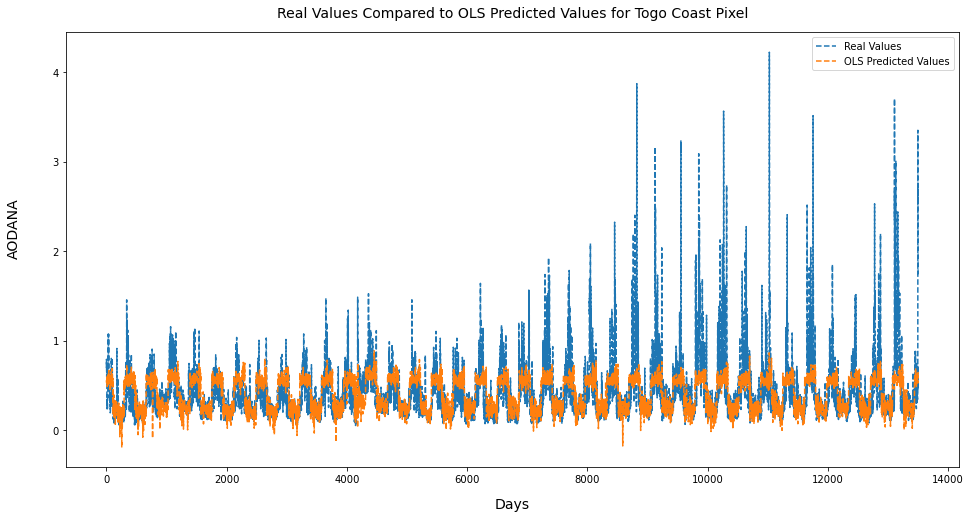

In [46]:
plot_ols_data(aod_reg_df, aod_reg_predictions, y_name= 'AODANA', x_name = 'Days', title='Real Values Compared to OLS Predicted Values for Togo Coast Pixel')

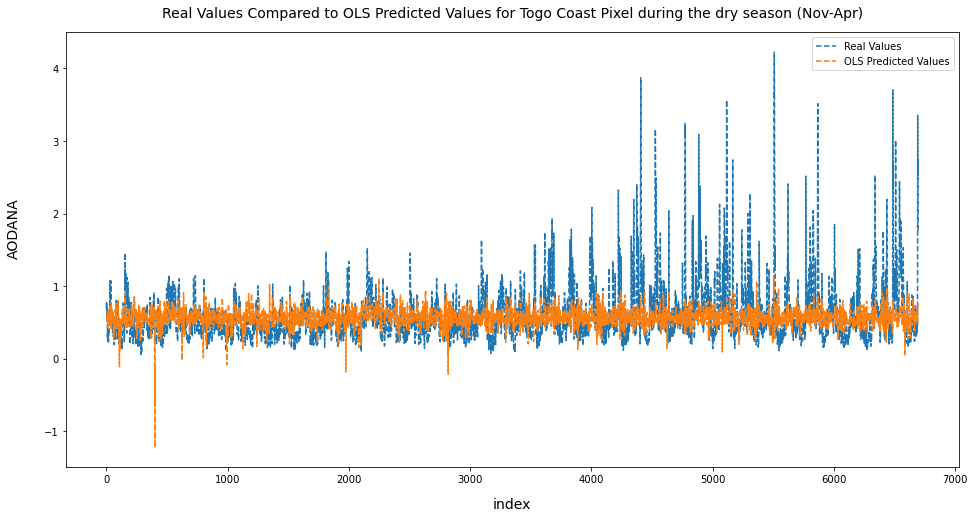

In [47]:
plot_ols_data(aod_reg_df[(aod_reg_df['dry_season']==True)], aod_reg_novapr_predictions, y_name= 'AODANA', x_name = 'index', title='Real Values Compared to OLS Predicted Values for Togo Coast Pixel during the dry season (Nov-Apr)')

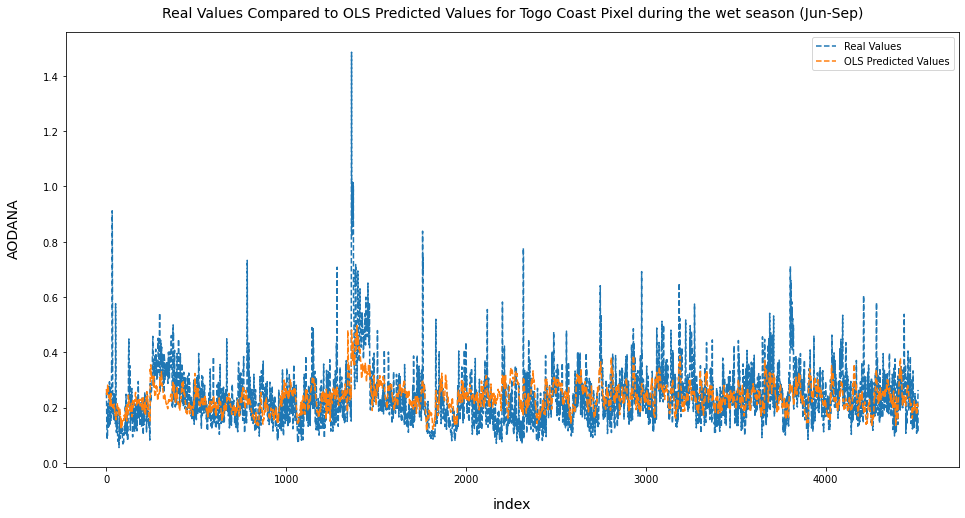

In [48]:
plot_ols_data(aod_reg_df[(aod_reg_df['wet_season']==True)], aod_reg_junsep_predictions, y_name= 'AODANA', x_name = 'index', title='Real Values Compared to OLS Predicted Values for Togo Coast Pixel during the wet season (Jun-Sep)')

In [49]:
predicted_daily_aod_data = np.load(parent_directory + '\\processed_data\\predicted_daily_aod_data.npy')
r_squared_map = np.load(parent_directory + '\\processed_data\\r_squared_map.npy')
mse_array = np.load(parent_directory + '\\processed_data\\mse_array.npy')

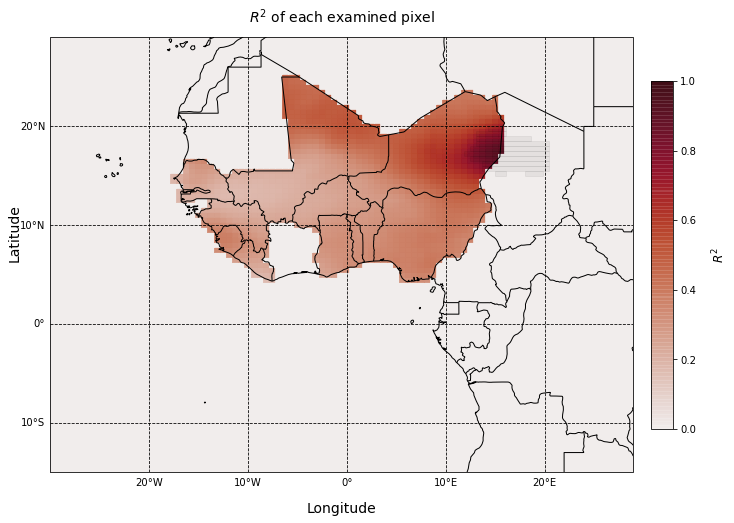

In [51]:
plot_merra_data(r_squared_map,
                west_africa_longitudes, west_africa_latitudes, title=r'$R^{2}$ of each examined pixel',
                date='', data_value=r'$R^{2}$', extent=[-30,29,-15,29], borders = True, add_bodele_source_exclusive= True, add_bodele_source_exclusive_alpha=.05,
                bodele = False, plot_grids = True, cbar_color = cmocean.tools.lighten(cmo.amp, 0.85), cbar_max = 1, unit = 1)

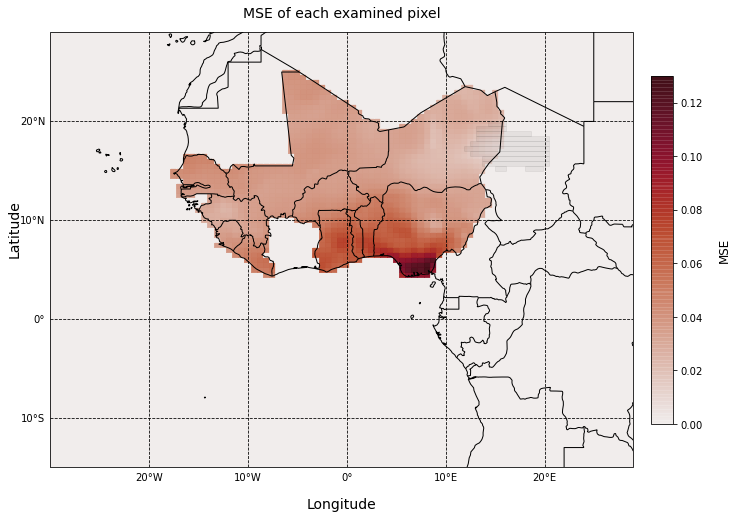

In [52]:
plot_merra_data(mse_array,
                west_africa_longitudes, west_africa_latitudes, title='MSE of each examined pixel',
                date='', data_value='MSE', extent=[-30,29,-15,29], borders = True, add_bodele_source_exclusive= True, add_bodele_source_exclusive_alpha=.05,
                bodele = False, plot_grids = True, cbar_color = cmocean.tools.lighten(cmo.amp, 0.85), cbar_max = .13, unit = 1)

In [53]:
benin_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_ben.csv')
burkina_faso_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_bfa.csv')
gambia_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_gmb.csv')
ghana_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_gha.csv')
guinea_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_gin.csv')
liberia_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_lbr.csv')
mali_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_mli.csv')
niger_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_ner.csv')
nigeria_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_nga.csv')
sierra_leone_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_sle.csv')
senegal_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_sen.csv')
togo_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_tgo.csv')

In [54]:
population_array = np.load(parent_directory + '\\processed_data\\population_array.npy')

# population_weigth_array = np.load(parent_directory + '\\processed_data\\population_weigth_array.npy')


c:\Users\Daniel\Desktop\Bachelor_thesis\new_topic\Code\functions.py:772: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(['no data', '0.2', '0.4', '0.6', '0.8',r'$\geq 1$'])


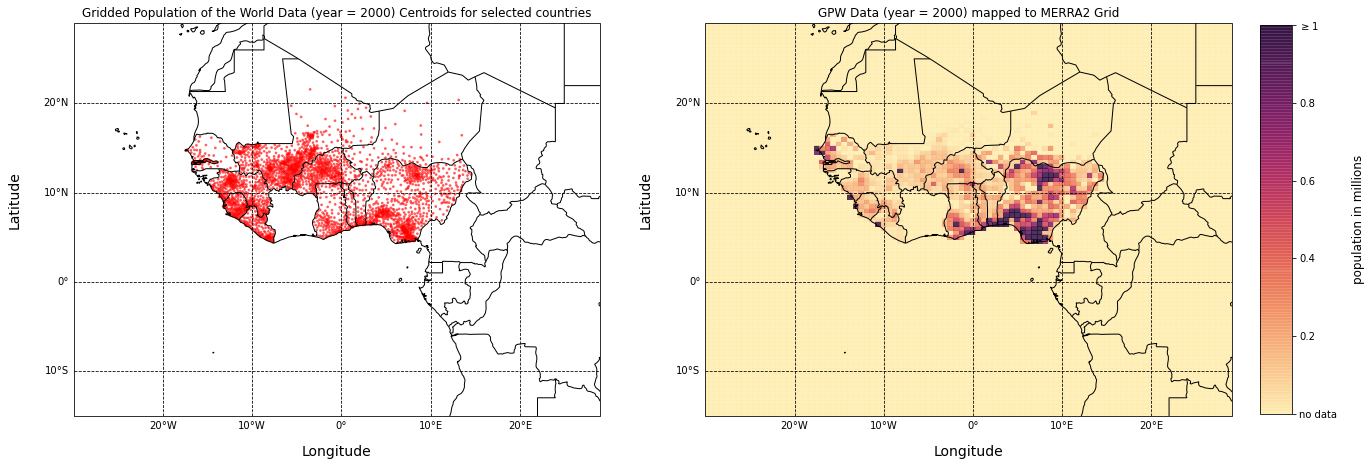

In [56]:
plot_gpw_data(population_array, west_africa_latitudes, west_africa_longitudes,
              extent=[-30,29,-15,29], borders = True,
              population_data = [benin_population_df, burkina_faso_population_df, gambia_population_df,
              ghana_population_df, guinea_population_df, liberia_population_df,
              mali_population_df, niger_population_df, nigeria_population_df,
              sierra_leone_population_df, senegal_population_df, togo_population_df])

In [20]:
population_weigth_array = create_population_weigth_array(population_array)

In [ ]:
mse_plot = np.zeros((13515, 91, 105), dtype='float32')



In [ ]:
def get_mse_data(aod_daily_data, predicted_daily_aod_data, countries_list):

    mse_array = np.zeros((13515, 91, 105), dtype='float32')
    
    for country in countries_list:

        country_pixels = return_region_pixel_array(country)

        for pixel in country_pixels:

            mse_array[:,pixel[0],pixel[1]] = aod_daily_data[:,pixel[0],pixel[1]]
    
    mse_array = np.abs(mse_array-predicted_daily_aod_data)**2

    np.sum(mse_array, axis=0)/mse_array.shape[0]

    return mse_array




In [45]:
def get_mse_data(aod_daily_data, predicted_daily_aod_data, countries_list):

    mse_plot = np.zeros((13515, 91, 105), dtype='float32')
        
    for country in countries_list:

        country_pixels = return_region_pixel_array(country)

        for pixel in country_pixels:

            mse_plot[:,pixel[0],pixel[1]] = aod_daily_data[:,pixel[0],pixel[1]]
            
    mse_plot = np.abs(mse_plot-predicted_daily_aod_data)**2
    mse_plot = np.sum(mse_plot, axis=0)/mse_plot.shape[0]

    return mse_plot

In [50]:
mse_plot = np.zeros((13515, 91, 105), dtype='float32')
        
for country in ['benin', 'burkina_faso', 'gambia', 'ghana', 'guinea', 'liberia','mali', 'niger', 'nigeria', 'sierra_leone', 'senegal', 'togo']:

    country_pixels = return_region_pixel_array(country)

    for pixel in country_pixels:

        mse_plot[:,pixel[0],pixel[1]] = aod_daily_data[:,pixel[0],pixel[1]]


mse_plot_1 = np.abs(mse_plot-predicted_daily_aod_data)**2

mse_plot = np.sum(mse_plot, axis=0)/mse_plot.shape[0]


In [47]:
mse_plot.max()

0.12600367

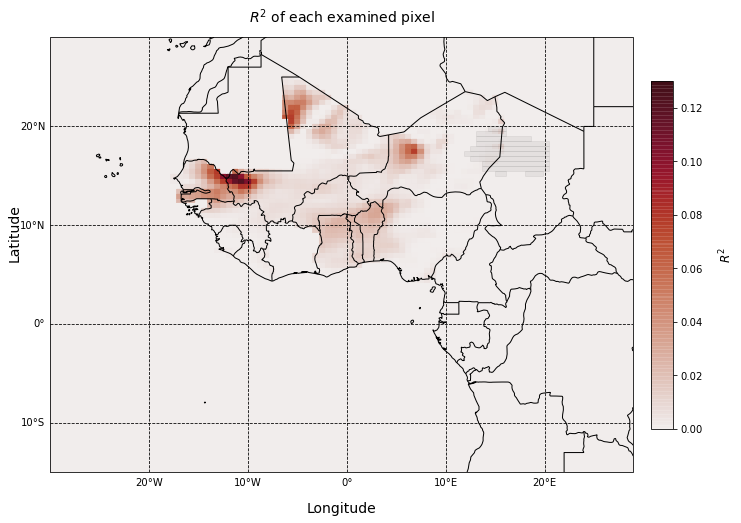

In [59]:
plot_merra_data(mse_plot_1[2000],
                west_africa_longitudes, west_africa_latitudes, title=r'$R^{2}$ of each examined pixel',
                date='', data_value=r'$R^{2}$', extent=[-30,29,-15,29], borders = True, add_bodele_source_exclusive= True, add_bodele_source_exclusive_alpha=.05,
                bodele = False, plot_grids = True, cbar_color = cmocean.tools.lighten(cmo.amp, 0.85), cbar_max = .13, unit = 1)

In [28]:
aod_daily_data.shape

(13515, 91, 105)

In [240]:
real_aod_mean = np.sum(aod_daily_data, axis = 0)/aod_daily_data.shape[0]
pred_aod_mean = np.sum(predicted_daily_aod_data, axis = 0)/predicted_daily_aod_data.shape[0]

In [259]:
real_aod_mean[40][35]

0.29260933

In [250]:
pred_aod_mean[40][35]

0.0

In [258]:
pred_aod_mean[40][35]

0.29265252

In [241]:
real_aod_mean.shape

#[-150, 150, -90, 90]

(91, 105)

In [273]:
diffr[diffr > .2] = 0

In [271]:
if diffr > .2:
    diffr = 0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

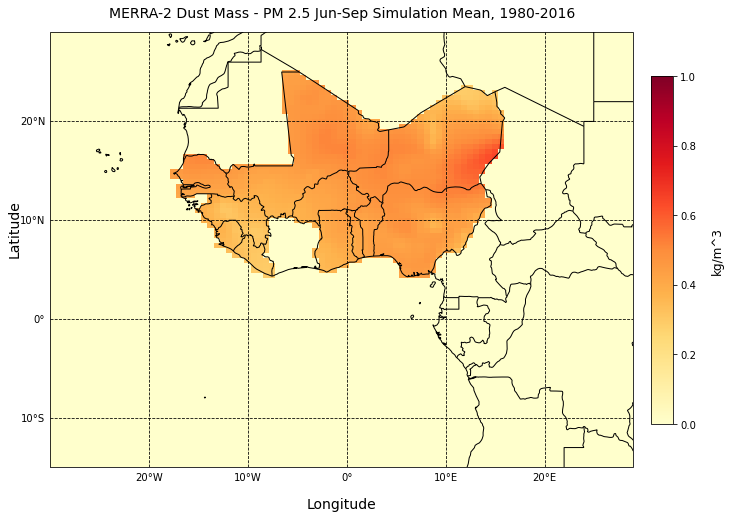

In [230]:
plot_merra_data(np.sum(predicted_daily_aod_data, axis = 0)/predicted_daily_aod_data.shape[0],
                west_africa_longitudes, west_africa_latitudes, title='Dust Mass - PM 2.5 Jun-Sep Simulation Mean',
                date='1980-2016', data_value='kg/m^3', extent=[-30,29,-15,29], borders = True,
                bodele = False, plot_grids = True, cbar_max = 1, unit = 1)

In [277]:
diffr[diffr > .05] = 0

In [279]:
diffr.max()

0.0011297166

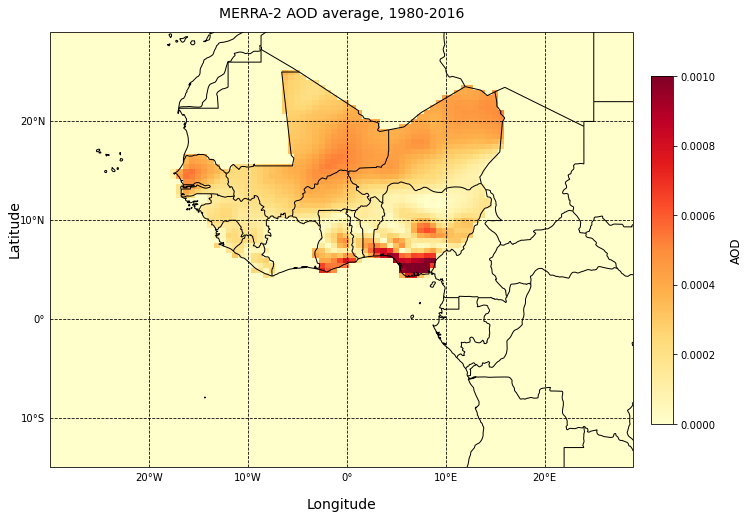

In [281]:
plot_merra_data(diffr,
                west_africa_longitudes, west_africa_latitudes,'AOD average', '1980-2016','AOD',
                extent=[-30,29,-15,29], borders = True, plot_grids=True, cbar_min = 0, cbar_max = 0.001)

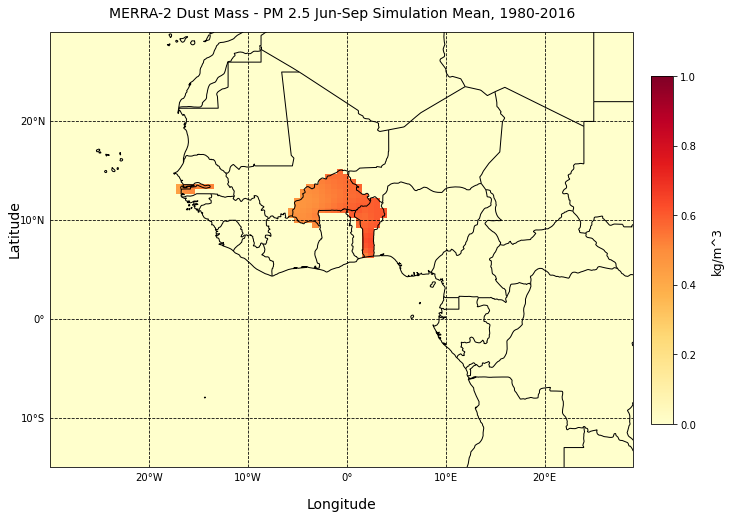

In [217]:
plot_merra_data(predicted_daily_aod_data[120],
                west_africa_longitudes, west_africa_latitudes, title='Dust Mass - PM 2.5 Jun-Sep Simulation Mean',
                date='1980-2016', data_value='kg/m^3', extent=[-30,29,-15,29], borders = True,
                bodele = False, plot_grids = True, cbar_max = 1, unit = 1)

In [ ]:
aod_reg_array = create_lag_regression_data(daily_bodele_aod_data, 10, [daily_togo_precipitation_data,daily_togo_temperature_data],
                                        daily_togo_coast_aod_data, daily_junsep_indices, daily_novapr_indices, dataframe=False,
                                        variable_names =   ['wet_season', 'dry_season', 'bod_aod_t-0', 'bod_aod_t-1',
                                                            'bod_aod_t-2', 'bod_aod_t-3','bod_aod_t-4', 'bod_aod_t-5',
                                                            'bod_aod_t-6', 'bod_aod_t-7','bod_aod_t-8', 'bod_aod_t-9',
                                                            'bod_aod_t-10', 'precipitation', 'temperature'],
                                        y_name = 'togo_coast_aod')

In [20]:
aod_reg_model_array = sm.OLS(daily_togo_coast_aod_data[10:-1], aod_reg_array).fit()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19643716, 0.03109794, 0.02122488, 0.01173193,
       0.00581118, 0.00474234, 0.01024051, 0.0014651 , 0.00335525,
       0.00179147, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00066336, 0.01078906,
       0.00938296, 0.01822356, 0.04031813, 0.02500711, 0.02660039,
       0.04236637, 0.02566165, 0.02985406, 0.03107947, 0.        ,
       0.01516271, 0.        , 0.03470445, 0.05679818, 0.02964801,
       0.02903344, 0.05273037, 0.09733477, 0.08516647, 0.02048282,
       0.        , 0.01805845, 0.04679666, 0.04265373, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [62]:
def create_population_weigth_array(population_array):
    max_value = population_array.max()

    population_array /= max_value
    population_array += 1

    return population_array

In [72]:
gpw.iloc[:,9:]

,CENTROID_X,CENTROID_Y,INSIDE_X,INSIDE_Y,CONTEXT,CONTEXT_NM,WATER_CODE,TOTAL_A_KM,WATER_A_KM,LAND_A_KM,...,A60_64M,A65PLUSM,A65_69M,A70PLUSM,A70_74M,A75PLUSM,A75_79M,A80PLUSM,A80_84M,A85PLUSM
0,-14.867966,13.209478,-14.867966,13.209478,0,Not applicable,L,4753.430100,0.000000,4753.430100,...,892.793458,1785.586916,750.758135,1034.828781,547.850531,486.978250,314.506786,172.471463,0.0,0.0
1,-14.845989,14.184394,-14.845989,14.184394,0,Not applicable,L,4401.286563,0.000000,4401.286563,...,1053.706128,2107.412256,886.071062,1221.341194,646.592397,574.748797,371.191931,203.556866,0.0,0.0
2,-13.123790,14.964818,-13.123790,14.964818,0,Not applicable,L,8607.220323,10.617010,8596.603313,...,1480.092723,2960.185446,1244.623426,1715.562020,908.238717,807.323304,521.396300,285.927003,0.0,0.0
3,-12.441666,12.763383,-12.441666,12.763383,0,Not applicable,L,7154.905924,0.000000,7154.905924,...,515.151213,1030.302425,433.195338,597.107087,316.115517,280.991571,181.473723,99.517848,0.0,0.0
4,-15.865121,16.269194,-15.865121,16.269194,0,Not applicable,L,5466.519062,224.070371,5242.446122,...,1588.772063,3177.544127,1336.012872,1841.531255,974.928312,866.602944,559.681068,306.921876,0.0,0.0
5,-15.901679,14.286594,-15.901679,14.286594,0,Not applicable,L,1204.308214,1.738125,1202.570089,...,738.043780,1476.087561,620.627724,855.459836,452.890502,402.569335,259.992695,142.576639,0.0,0.0
6,-16.608159,12.464049,-16.608159,12.464049,0,Not applicable,L,840.395646,34.272913,806.122733,...,317.693127,635.386254,267.151039,368.235215,194.948055,173.287160,111.914624,61.372536,0.0,0.0
7,-13.879787,12.988764,-13.879787,12.988764,0,Not applicable,L,5370.176532,2.478859,5367.697673,...,1792.291152,3584.582303,1507.153923,2077.428380,1099.815025,977.613355,631.375292,346.238063,0.0,0.0
8,-13.598104,15.728306,-13.598104,15.728306,0,Not applicable,L,5323.872750,20.130421,5303.742329,...,1708.065643,3416.131285,1436.327927,1979.803358,1048.131190,931.672169,601.704942,329.967226,0.0,0.0
9,-15.514706,12.632132,-15.514706,12.632132,0,Not applicable,L,1821.857665,170.822003,1651.033235,...,997.538858,1995.077716,838.839494,1156.238222,612.126118,544.112104,351.405734,192.706370,0.0,0.0


-19.375


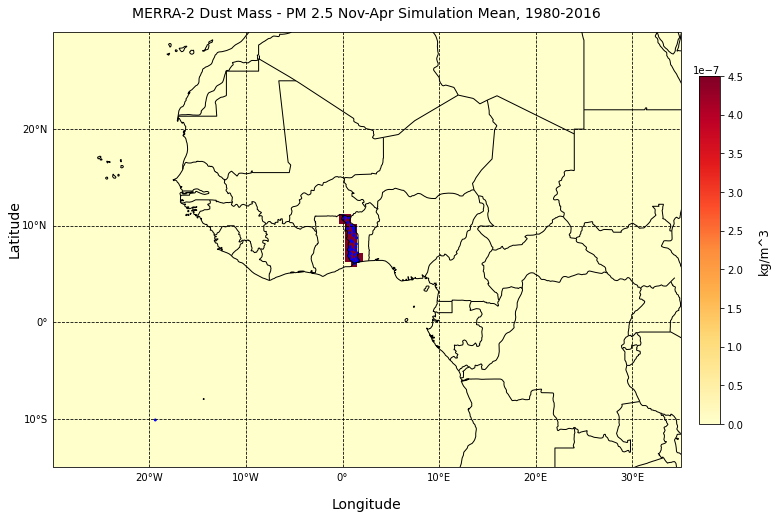

(91,)

In [381]:
dot = np.zeros((91,105), dtype = 'float32')

gpw = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_tgo.csv')
pop = map_population_to_pixel(west_africa_longitudes, west_africa_latitudes, gpw['CENTROID_X'], gpw['CENTROID_Y'], gpw['UN_2000_E'])

togo_pixels = np.array([[42,50],
                                [43,49],[43,50],[43,51],
                                [44,49],[44,50],[44,51],
                                [45,49],[45,50],
                                [46,49],[46,50],
                                [47,49],[47,50],
                                [48,49],[48,50],
                                [49,49],[49,50],
                                [50,49],[50,50],
                                [51,48],[51,49],
                                [52,48],[52,49]], dtype = 'int')


# for pix in senegal_pixels:
#     dot[round(pix[0])][round(pix[1])] = .5

# dot = pop

for pix in togo_pixels:
    dot[pix[0]][pix[1]] = .5


simulated_dustmass_hourly_data_2 = simulated_dustmass_hourly_data
simulated_dustmass_hourly_data_2[50][56][22] = 1

# dot[56][24] = 1
# dot[56][30] = 1
print(west_africa_longitudes[17])

# for idx, x_coord in enumerate(pop_df.iloc[:,9]):
        # ax.add_patch(plt.Circle((x_coord, pop_df.iloc[idx,10]), .1, color='r'))

# plot_merra_data(dot,
#                 west_africa_longitudes, west_africa_latitudes, gpw, -19.375,-10.1,.1,title='Dust Mass - PM 2.5 Nov-Apr Simulation Mean',
#                 date='1980-2016', data_value='kg/m^3', extent=[-30,35,30,-15], borders = True,
#                 bodele = False, plot_grids = True, cbar_max = 4.5, unit = 10 ** -7, pop_df_b = True)

plot_merra_data(dot,
                west_africa_longitudes, west_africa_latitudes, gpw, -19.375,-10.1,.1,title='Dust Mass - PM 2.5 Nov-Apr Simulation Mean',
                date='1980-2016', data_value='kg/m^3', extent=[-30,35,30,-15], borders = True,
                bodele = False, plot_grids = True, cbar_max = 4.5, unit = 10 ** -7, pop_df_b = True)
	
# plot_merra_data(pop,
#                 west_africa_longitudes, west_africa_latitudes,[], -14.867966,13.209478,.1,title='Dust Mass - PM 2.5 Nov-Apr Simulation Mean',
#                 date='1980-2016', data_value='kg/m^3', extent=[-30,35,30,-15], borders = True,
#                 bodele = False, plot_grids = True, cbar_max = 4.5, unit = 10 ** -7)

# pop.shape
# dot.shape
west_africa_latitudes.shape

In [221]:
# taken from unutbu's answer: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def map_population_to_pixel(longitudes, latitudes, x_coords, y_coords, pop_values):
    population = np.zeros((91,105))
    for idx, x_coord in enumerate(x_coords):
        x_pixel = find_nearest(longitudes, x_coord)
        y_pixel = find_nearest(latitudes, y_coords[idx])
        population[y_pixel][x_pixel] += pop_values[idx]
    return population

pop = map_population_to_pixel(west_africa_longitudes, west_africa_latitudes, gpw['CENTROID_X'], gpw['CENTROID_Y'], gpw['UN_2000_E'])


In [222]:
pop = map_population_to_pixel(west_africa_longitudes, west_africa_latitudes, gpw['CENTROID_X'], gpw['CENTROID_Y'], gpw['UN_2000_E'])

100793.0

In [145]:
pop[20][12] =2

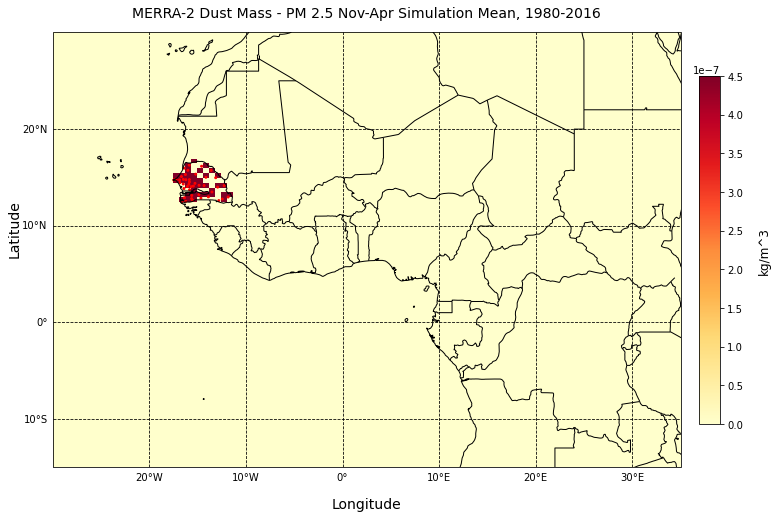

In [152]:
plot_merra_data(pop,
                west_africa_longitudes, west_africa_latitudes, gpw, title='Dust Mass - PM 2.5 Nov-Apr Simulation Mean',
                date='1980-2016', data_value='kg/m^3', extent=[-30,35,30,-15], borders = True,
                bodele = False, plot_grids = True, cbar_max = 4.5, unit = 10 ** -7)

In [131]:
gpw['UN_2000_E']

0    -14.867966
1    -14.845989
2    -13.123790
3    -12.441666
4    -15.865121
5    -15.901679
6    -16.608159
7    -13.879787
8    -13.598104
9    -15.514706
10   -15.192032
11   -14.582207
12   -12.804268
13   -14.135782
14   -15.668321
15   -12.249965
16   -16.002036
17   -16.410065
18   -15.435403
19   -16.480179
20   -16.212740
21   -14.650506
22   -16.254638
23   -13.510440
24   -15.844835
25   -15.267228
26   -16.207962
27   -16.357225
28   -15.846257
29   -11.837257
30   -17.397950
31   -16.863977
32   -16.665255
33   -15.824713
34   -15.618298
35   -16.054450
36   -17.209325
37   -15.600539
38   -16.826906
39   -12.922749
40   -16.474309
41   -16.378922
42   -17.460823
43   -14.326487
44   -17.352149
Name: CENTROID_X, dtype: float64

In [103]:
west_africa_longitudes[0]

-30.0

In [39]:
dot[20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.])

In [202]:
gpw = pd.read_csv('gpw_v4_admin_unit_center_points_population_estimates_rev11_sen.csv')


In [132]:
gpw.iloc[:, 9:]

,CENTROID_X,CENTROID_Y,INSIDE_X,INSIDE_Y,CONTEXT,CONTEXT_NM,WATER_CODE,TOTAL_A_KM,WATER_A_KM,LAND_A_KM,...,A60_64M,A65PLUSM,A65_69M,A70PLUSM,A70_74M,A75PLUSM,A75_79M,A80PLUSM,A80_84M,A85PLUSM
0,-14.867966,13.209478,-14.867966,13.209478,0,Not applicable,L,4753.430100,0.000000,4753.430100,...,892.793458,1785.586916,750.758135,1034.828781,547.850531,486.978250,314.506786,172.471463,0.0,0.0
1,-14.845989,14.184394,-14.845989,14.184394,0,Not applicable,L,4401.286563,0.000000,4401.286563,...,1053.706128,2107.412256,886.071062,1221.341194,646.592397,574.748797,371.191931,203.556866,0.0,0.0
2,-13.123790,14.964818,-13.123790,14.964818,0,Not applicable,L,8607.220323,10.617010,8596.603313,...,1480.092723,2960.185446,1244.623426,1715.562020,908.238717,807.323304,521.396300,285.927003,0.0,0.0
3,-12.441666,12.763383,-12.441666,12.763383,0,Not applicable,L,7154.905924,0.000000,7154.905924,...,515.151213,1030.302425,433.195338,597.107087,316.115517,280.991571,181.473723,99.517848,0.0,0.0
4,-15.865121,16.269194,-15.865121,16.269194,0,Not applicable,L,5466.519062,224.070371,5242.446122,...,1588.772063,3177.544127,1336.012872,1841.531255,974.928312,866.602944,559.681068,306.921876,0.0,0.0
5,-15.901679,14.286594,-15.901679,14.286594,0,Not applicable,L,1204.308214,1.738125,1202.570089,...,738.043780,1476.087561,620.627724,855.459836,452.890502,402.569335,259.992695,142.576639,0.0,0.0
6,-16.608159,12.464049,-16.608159,12.464049,0,Not applicable,L,840.395646,34.272913,806.122733,...,317.693127,635.386254,267.151039,368.235215,194.948055,173.287160,111.914624,61.372536,0.0,0.0
7,-13.879787,12.988764,-13.879787,12.988764,0,Not applicable,L,5370.176532,2.478859,5367.697673,...,1792.291152,3584.582303,1507.153923,2077.428380,1099.815025,977.613355,631.375292,346.238063,0.0,0.0
8,-13.598104,15.728306,-13.598104,15.728306,0,Not applicable,L,5323.872750,20.130421,5303.742329,...,1708.065643,3416.131285,1436.327927,1979.803358,1048.131190,931.672169,601.704942,329.967226,0.0,0.0
9,-15.514706,12.632132,-15.514706,12.632132,0,Not applicable,L,1821.857665,170.822003,1651.033235,...,997.538858,1995.077716,838.839494,1156.238222,612.126118,544.112104,351.405734,192.706370,0.0,0.0


In [99]:
gpw.iloc[:,[11,12,19]].sort_values('INSIDE_X')

,INSIDE_X,INSIDE_Y,UN_2000_E
42,-17.460823,14.722017,836553
30,-17.397950,14.770083,240632
44,-17.352149,14.763806,854610
36,-17.209325,14.756128,358178
31,-16.863977,14.744112,487465
38,-16.826906,14.460538,488244
32,-16.665255,15.086800,330058
6,-16.608159,12.464049,35279
19,-16.480179,14.317136,247625
40,-16.474309,14.795880,218601


In [103]:
gpw.iloc[:,[11,12,19]].sort_values('INSIDE_Y')

,INSIDE_X,INSIDE_Y,UN_2000_E
6,-16.608159,12.464049,35279
20,-16.212740,12.518159,181218
12,-12.804268,12.600068,16139
9,-15.514706,12.632132,113941
3,-12.441666,12.763383,57317
34,-15.618298,12.806703,110461
21,-14.650506,12.852019,179558
27,-16.357225,12.893353,184351
29,-11.837257,12.966379,37026
7,-13.879787,12.988764,203203


In [88]:
np.sort(gpw['INSIDE_X'])

AttributeError: module 'pandas' has no attribute 'sort'

In [101]:
sen_latitudes = gpw.iloc[:,[11]].sort_values('INSIDE_X')
sen_longitudes = gpw.iloc[:,[12]].sort_values('INSIDE_Y')

In [121]:
datlo = np.zeros((45,45))

TypeError: Shape of x does not match that of z: found (45, 1) instead of (45, 45).

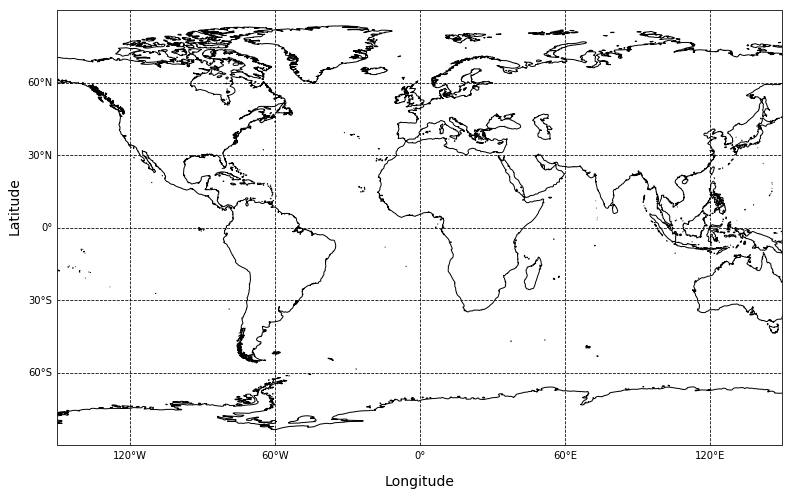

In [122]:
plot_merra_data(datlo, sen_longitudes, sen_latitudes)

In [226]:
aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[10: ,[0,3,14,15]].to_csv('aod_reg_df_novapr.csv', index=False)

In [231]:
aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[10: ,[0,3,14,15]]

,togo_coast_aod,bod_aod_t-0,precipitation,temperature
10,0.656982,0.300951,0.000005,299.812286
11,0.776667,0.267749,0.000005,299.877716
12,0.692125,0.283572,0.000004,299.858826
13,0.642311,0.391012,0.000003,299.990845
14,0.643428,0.419689,0.000004,300.372284
...,...,...,...,...
13510,3.585607,0.568435,0.000000,300.608551
13511,2.639982,0.391849,0.000000,299.721893
13512,2.769433,0.358855,0.000000,299.391174
13513,1.851733,0.390831,0.000000,299.583649


In [207]:
aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: ,[0,3,14,15]].to_csv('aod_reg_df_junsep.csv', index=False)

In [197]:
from statsmodels.tsa.api import VAR

aod_model_novapr_var = VAR(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: ,[0,3,14,15]])


aod_model_junsep_var = VAR(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: ,[0,3,14,15]])


results_aod_novapr = aod_model_novapr_var.fit(10)
results_aod_novapr.summary()

results_aod_junsep = aod_model_junsep_var.fit(10)
results_aod_junsep.summary()


C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Apr, 2022
Time:                     15:35:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -32.0273
Nobs:                     4504.00    HQIC:                  -32.1785
Log likelihood:           47251.8    FPE:                9.75678e-15
AIC:                     -32.2608    Det(Omega_mle):     9.40945e-15
--------------------------------------------------------------------
Results for equation togo_coast_aod
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -1.065921         0.381644           -2.793           0.005
L1.togo_coast_aod          0.736209         0.014961           49.210           0.000
L1.bod_aod_t-0             0.05

In [241]:
fitted_aod_novapr = aod_model_novapr_var.fit()

In [242]:
J = fitted_aod_novapr.ma_rep(30)
J = 1*np.array(J)

In [244]:
G, H = fitted_aod_novapr.irf_errband_mc(orth=False, repl=1000, steps=30, signif=0.05, seed=None, burn=100, cum=False)

In [246]:
H

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 8.72690292e-01,  1.28700751e-01, -3.92057372e+02,
          3.73851388e-03],
        [-5.86401931e-03,  8.02244389e-01,  2.86245295e+02,
          7.35914367e-03],
        [-4.11453036e-06,  1.36756555e-05,  6.65354892e-01,
          3.24175214e-06],
        [-2.02357307e-01,  5.08098742e-01,  1.13567339e+03,
          8.66770298e-01]],

       [[ 7.61927565e-01,  2.07099279e-01, -5.72084326e+02,
          5.50992438e-03],
        [-1.36013876e-02,  6.44475241e-01,  4.10799661e+02,
          1.26142346e-02],
        [-7.57712433e-06,  1.91264235e-05,  4.46772852e-01,
          4.90420338e-06],
        [-3.41369658e-01,  7.58691388e-

In [205]:
results_aod_novapr.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Apr, 2022
Time:                     15:40:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.4978
Nobs:                     6697.00    HQIC:                  -26.6069
Log likelihood:           51439.7    FPE:                2.62870e-12
AIC:                     -26.6645    Det(Omega_mle):     2.56530e-12
--------------------------------------------------------------------
Results for equation togo_coast_aod
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      1.021970         1.095414            0.933           0.351
L1.togo_coast_aod          0.953147         0.012346           77.201           0.000
L1.bod_aod_t-0            -0.02

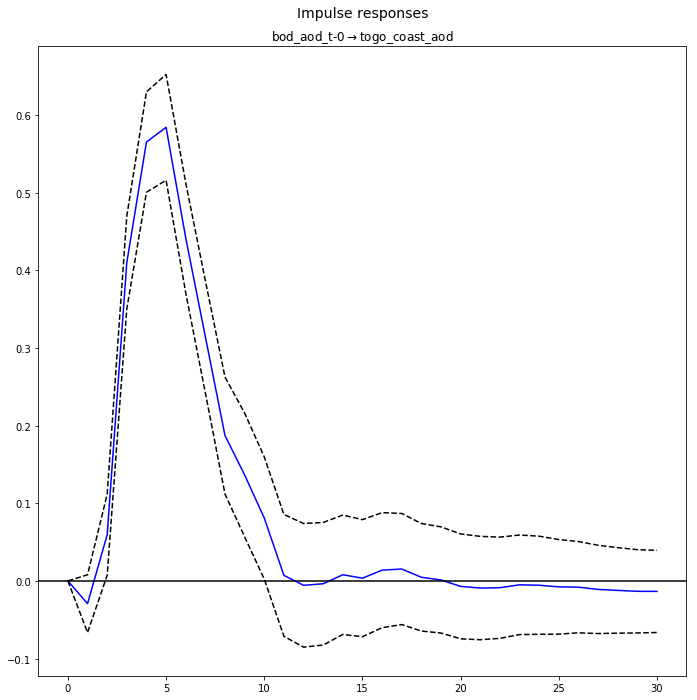

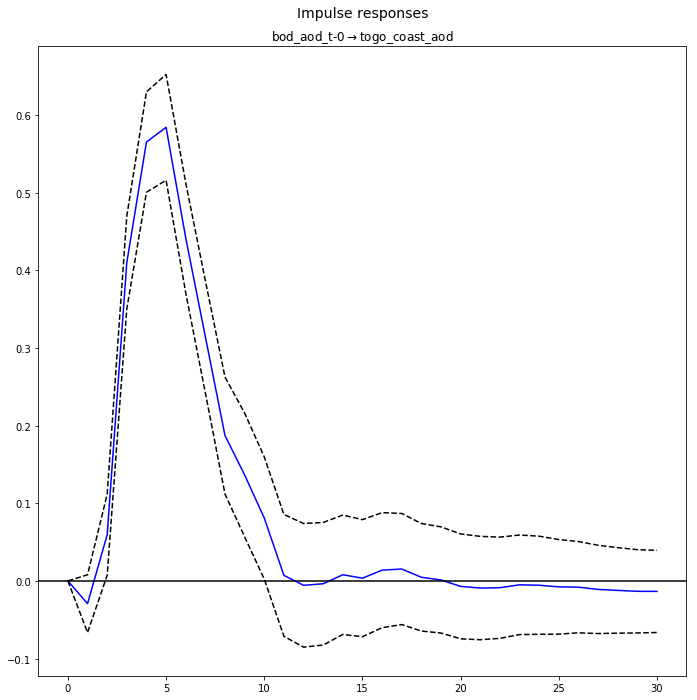

In [238]:
irf_aod_novapr = results_aod_novapr.irf(30)
irf_aod_novapr.plot(orth=False, impulse = 'bod_aod_t-0', response='togo_coast_aod')

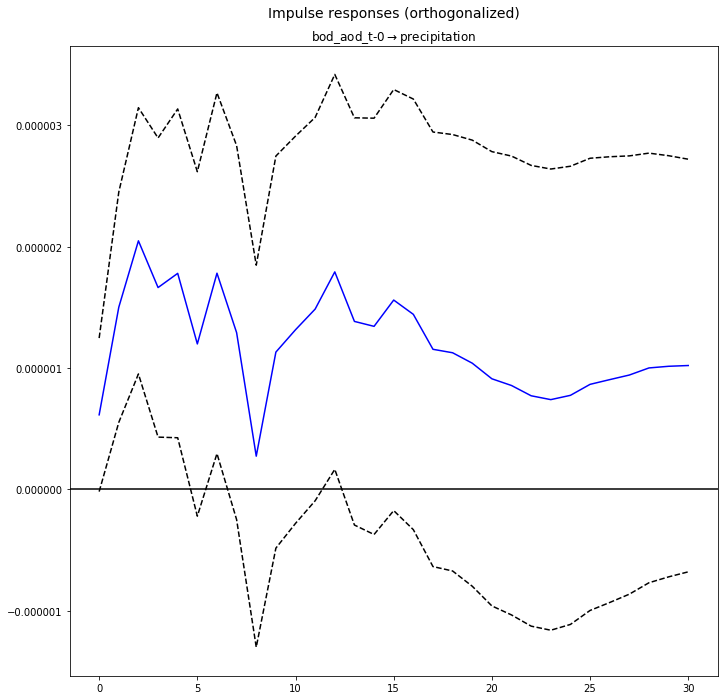

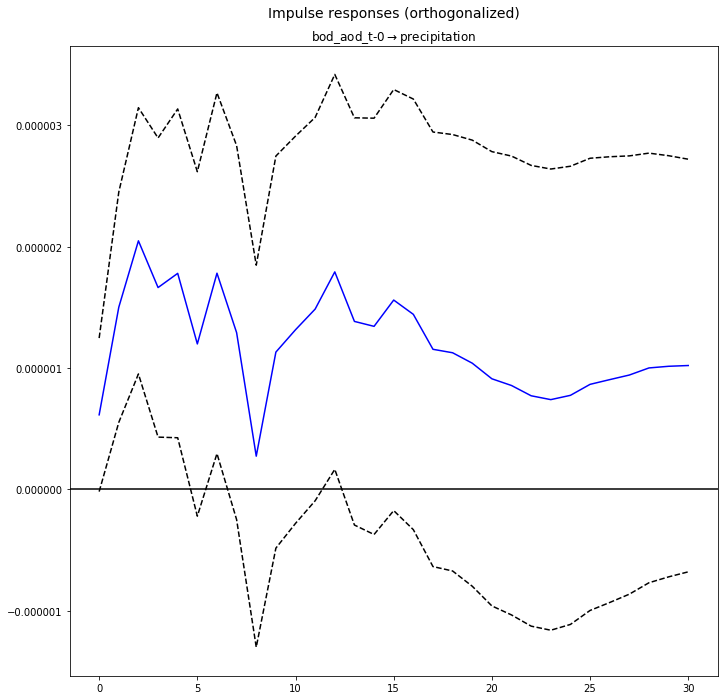

In [220]:
irf_aod_novapr = results_aod_novapr.irf(30)
irf_aod_novapr.plot(orth=True, impulse = 'bod_aod_t-0', response='precipitation')

In [234]:
print(irf_aod_novapr)

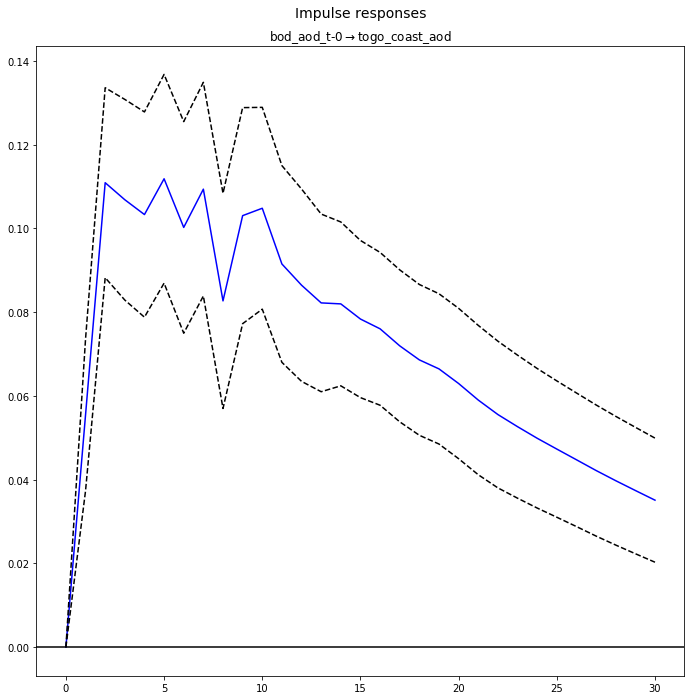

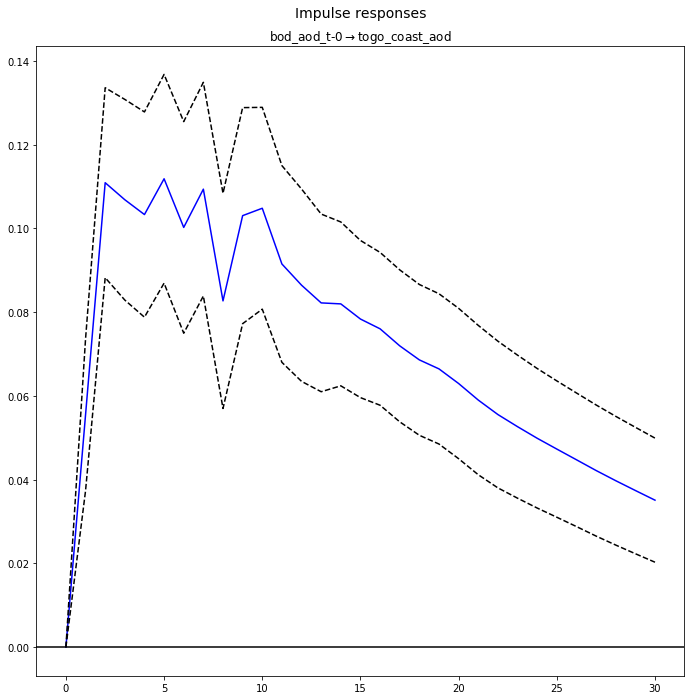

In [200]:
irf_aod_junsep = results_aod_junsep.irf(30)
irf_aod_junsep.plot(orth=False, impulse = 'bod_aod_t-0', response='togo_coast_aod')

In [63]:
#setting up linear regression
# from sklearn import linear_model
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_array_rhs, daily_togo_coast_aod_data)


In [64]:
r_sq = model.score(x_array_rhs, daily_togo_coast_aod_data)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.32087643557058365
intercept: [-0.70853877]
slope: [[-1.62201735e-02  3.20348212e-01 -9.75813625e-02  1.93104237e-02
   3.60195299e-02  1.56003447e-01  7.04947284e-02  7.85397206e-02
  -4.68893105e-03  2.69581354e-02 -2.62886054e-02  2.89691062e-02
  -4.24490202e-02 -7.98979937e+02  2.84568955e-03]]


In [239]:
X_array_novapr_pred_test = np.zeros((1,11))

X_array_novapr_pred_test[0,10] = 0    #mean dust over Bodélé Depression 10 days prior
X_array_novapr_pred_test[0,9] = 0      #mean dust over Bodélé Depression 9 days prior
X_array_novapr_pred_test[0,8] = 0      #mean dust over Bodélé Depression 8 days prior
X_array_novapr_pred_test[0,7] = 0      #mean dust over Bodélé Depression 7 days prior
X_array_novapr_pred_test[0,6] = 0      #mean dust over Bodélé Depression 6 days prior
X_array_novapr_pred_test[0,5] = 0      #mean dust over Bodélé Depression 5 days prior
X_array_novapr_pred_test[0,4] = 0      #mean dust over Bodélé Depression 4 days prior
X_array_novapr_pred_test[0,3] = 0      #mean dust over Bodélé Depression 3 days prior
X_array_novapr_pred_test[0,2] = 0      #mean dust over Bodélé Depression 2 days prior
X_array_novapr_pred_test[0,1] = 0      #mean dust over Bodélé Depression 1 day prior
X_array_novapr_pred_test[0,0] = 1      #mean dust over Bodélé Depression 0 days prior

y_pred = model.predict(X_array_novapr_pred_test)
print('predicted response:', y_pred, sep='\n')

# X_array_novapr_pred_test.reshape(1, -1)

NameError: name 'model' is not defined

In [71]:
y_pred = model.predict(X_array_novapr_pred_test)
print('predicted response:', y_pred, sep='\n')

predicted response:
[0.00843214]


In [90]:
# predicted response:
y = [0.0336247, 0.00843214, 0.02464734, 0.03620843, 0.0432065, 0.06167843, 0.0663656, 0.08633359, 0.06307776,0.01946429,0.0474755]
x = range(-10,1)


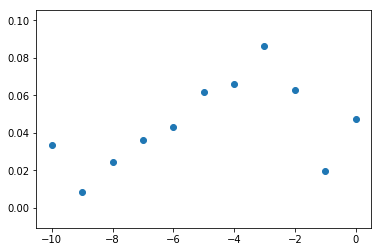

In [91]:
plt.scatter(x,y)

In [ ]:
x_array_rhs, daily_togo_coast_aod_data

In [70]:
X_array_df = pd.DataFrame(x_array_rhs, columns =           ['wet_season', 'dry_season', 'bod_dust_t-10', 'bod_dust_t-9', 'bod_dust_t-8', 'bod_dust_t-7',
                                                            'bod_dust_t-6', 'bod_dust_t-5', 'bod_dust_t-4', 'bod_dust_t-3',
                                                            'bod_dust_t-2', 'bod_dust_t-1', 'bod_dust_t-0', 'precipitation', 'temperature'])

In [87]:
Y_array_df = pd.DataFrame(daily_togo_coast_aod_data, columns = ['togo_coast_aod'])

In [88]:
Y_array_df

,togo_coast_aod
0,0.465508
1,0.333683
2,0.679779
3,0.699667
4,0.559007
...,...
13510,3.585607
13511,2.639982
13512,2.769433
13513,1.851733


In [89]:
combo_df = X_array_df
combo_df.insert(2, 'Togo', Y_array_df, True)

In [90]:
combo_df

,wet_season,dry_season,Togo,bod_dust_t-10,bod_dust_t-9,bod_dust_t-8,bod_dust_t-7,bod_dust_t-6,bod_dust_t-5,bod_dust_t-4,bod_dust_t-3,bod_dust_t-2,bod_dust_t-1,bod_dust_t-0,precipitation,temperature
0,0.0,1.0,0.465508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,312.272125
1,0.0,1.0,0.333683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.173676
2,0.0,1.0,0.679779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.438110
3,0.0,1.0,0.699667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.344604
4,0.0,1.0,0.559007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.184906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13510,0.0,1.0,3.585607,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.543359,0.386547,0.316047,0.0,300.608551
13511,0.0,1.0,2.639982,0.391849,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.543359,0.386547,0.0,299.721893
13512,0.0,1.0,2.769433,0.358855,0.391849,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.543359,0.0,299.391174
13513,0.0,1.0,1.851733,0.390831,0.358855,0.391849,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.0,299.583649


In [95]:
X_array_df_novapr = combo_df[(combo_df['wet_season']==True)]
X_array_df_junsep = combo_df[(combo_df['dry_season']==True)]

In [96]:
X_array_df_novapr.iloc[: , 2:]
X_array_df_junsep.iloc[: , 2:]

,Togo,bod_dust_t-10,bod_dust_t-9,bod_dust_t-8,bod_dust_t-7,bod_dust_t-6,bod_dust_t-5,bod_dust_t-4,bod_dust_t-3,bod_dust_t-2,bod_dust_t-1,bod_dust_t-0,precipitation,temperature
0,0.465508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,312.272125
1,0.333683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.173676
2,0.679779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.438110
3,0.699667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.344604
4,0.559007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,300.184906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13510,3.585607,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.543359,0.386547,0.316047,0.0,300.608551
13511,2.639982,0.391849,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.543359,0.386547,0.0,299.721893
13512,2.769433,0.358855,0.391849,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.543359,0.0,299.391174
13513,1.851733,0.390831,0.358855,0.391849,0.568435,0.580700,0.721386,0.754914,0.362737,0.263234,0.339963,0.538718,0.0,299.583649


In [99]:
X_array_df_novapr.iloc[: ,13:]

,bod_dust_t-0,precipitation,temperature
152,0.850986,0.000108,299.206146
153,0.770725,0.000159,299.050201
154,0.767311,0.000114,299.137695
155,0.683817,0.000034,298.942780
156,0.718057,0.000016,298.512360
...,...,...,...
13418,0.610252,0.000088,298.074738
13419,0.569546,0.000063,298.732758
13420,0.478847,0.000026,298.545258
13421,0.433945,0.000025,299.170410


In [112]:
model_novapr = sm.OLS(X_array_df_novapr.iloc[: , 2], X_array_df_novapr.iloc[: , 3:]).fit()
model_junsep = sm.OLS(X_array_df_junsep.iloc[: , 2], X_array_df_junsep.iloc[: , 3:]).fit()

predictions_novapr = model.predict(X_array_df_novapr.iloc[: , 3:]) 
predictions_junsep = model.predict(X_array_df_junsep.iloc[: , 3:]) 


print_model_novapr = model_novapr.summary()
print(print_model_novapr)
# print_model_junsep = model_junsep.summary()
# print(print_model_junsep)

# model_95 = model.conf_int(alpha=0.05, cols=None)

                                 OLS Regression Results                                
Dep. Variable:                   Togo   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              2525.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):                        0.00
Time:                        11:32:07   Log-Likelihood:                          4326.4
No. Observations:                4514   AIC:                                     -8627.
Df Residuals:                    4501   BIC:                                     -8543.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [107]:
X_array_df_novapr.iloc[: ,[2,13,14,15]]

,Togo,bod_dust_t-0,precipitation,temperature
152,0.230943,0.850986,0.000108,299.206146
153,0.207556,0.770725,0.000159,299.050201
154,0.148230,0.767311,0.000114,299.137695
155,0.130243,0.683817,0.000034,298.942780
156,0.093909,0.718057,0.000016,298.512360
...,...,...,...,...
13418,0.173068,0.610252,0.000088,298.074738
13419,0.141255,0.569546,0.000063,298.732758
13420,0.113317,0.478847,0.000026,298.545258
13421,0.215612,0.433945,0.000025,299.170410


In [118]:
from statsmodels.tsa.api import VAR

model_novapr_var = VAR(X_array_df_novapr.iloc[: ,[2,13,14,15]])

model_novapr_var_t = VAR(X_array_df_novapr.iloc[: ,[2,13]])


model_junsep_var = VAR(X_array_df_junsep.iloc[: ,[2,13,14,15]])


results = model_novapr_var.fit(10)

results_t = model_novapr_var_t.fit(10)

results.summary()

# results2 = model_junsep_var.fit(10)

# results2.summary()


C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Apr, 2022
Time:                     12:15:56
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -31.9695
Nobs:                     4504.00    HQIC:                  -32.1207
Log likelihood:           47121.5    FPE:                1.03377e-14
AIC:                     -32.2030    Det(Omega_mle):     9.96971e-15
--------------------------------------------------------------------
Results for equation Togo
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.845020         0.388101           -2.177           0.029
L1.Togo                   0.766084         0.014976           51.155           0.000
L1.bod_dust_t-0           0.004908         0.

In [126]:
X_array_novapr_pred_test = np.zeros((1,13))

X_array_novapr_pred_test[0,0] = 0      #mean dust over Bodélé Depression 0 days prior
X_array_novapr_pred_test[0,1] = 1      #mean dust over Bodélé Depression 1 day prior
X_array_novapr_pred_test[0,2] = 0      #mean dust over Bodélé Depression 2 days prior
X_array_novapr_pred_test[0,3] = 0      #mean dust over Bodélé Depression 3 days prior
X_array_novapr_pred_test[0,4] = 0      #mean dust over Bodélé Depression 4 days prior
X_array_novapr_pred_test[0,5] = 0      #mean dust over Bodélé Depression 5 days prior
X_array_novapr_pred_test[0,6] = 0      #mean dust over Bodélé Depression 6 days prior
X_array_novapr_pred_test[0,7] = 0      #mean dust over Bodélé Depression 7 days prior
X_array_novapr_pred_test[0,8] = 0      #mean dust over Bodélé Depression 8 days prior
X_array_novapr_pred_test[0,9] = 0      #mean dust over Bodélé Depression 9 days prior
X_array_novapr_pred_test[0,10] = 0     #mean dust over Bodélé Depression 10 days prior
X_array_novapr_pred_test[0,11] = 0     #precipitaton
X_array_novapr_pred_test[0,12] = 0     #temperature


y_pred = model_novapr.predict(X_array_novapr_pred_test)
print('predicted response:', y_pred, sep='\n')

predicted response:
[0.04106589]


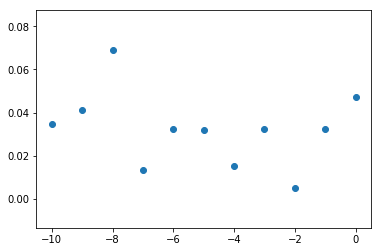

In [127]:
# y = [0.0336247, 0.00843214, 0.02464734, 0.03620843, 0.0432065, 0.06167843, 0.0663656, 0.08633359, 0.06307776,0.01946429,0.0474755]
y = [0.03460979, 0.0411, 0.0690, 0.0134, 0.0326, 0.0321, 0.0154, 0.0322, 0.0050, 0.0324, 0.0471]

x = range(-10,1)
plt.scatter(x,y)

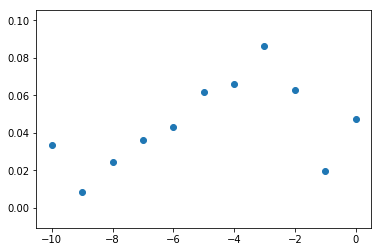

In [128]:
y = [0.0336247, 0.00843214, 0.02464734, 0.03620843, 0.0432065, 0.06167843, 0.0663656, 0.08633359, 0.06307776,0.01946429,0.0474755]
x = range(-10,1)
plt.scatter(x,y)

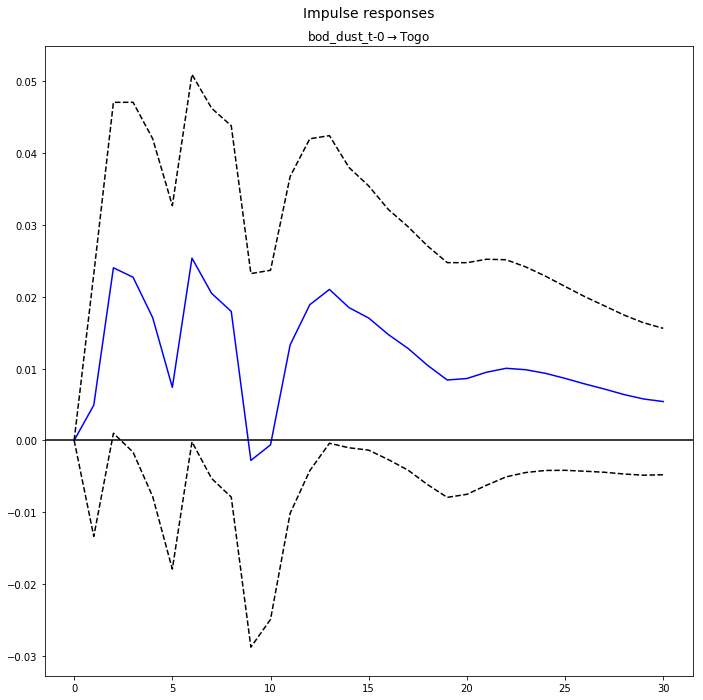

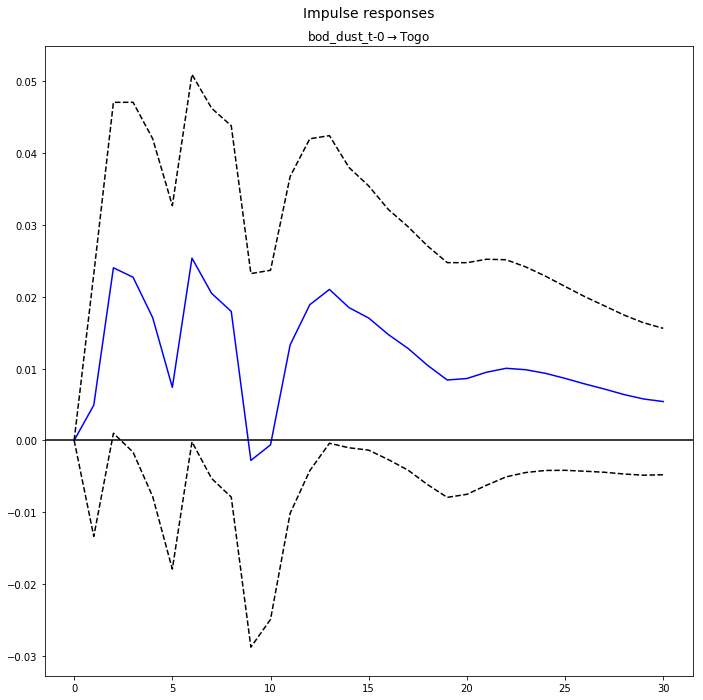

In [117]:
irf = results.irf(30)
irf.plot(orth=False, impulse = 'bod_dust_t-0', response='Togo')

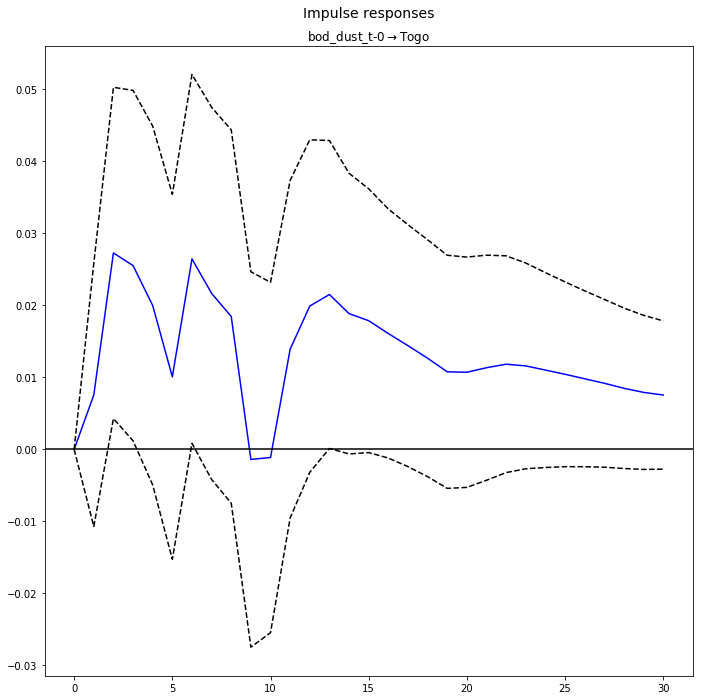

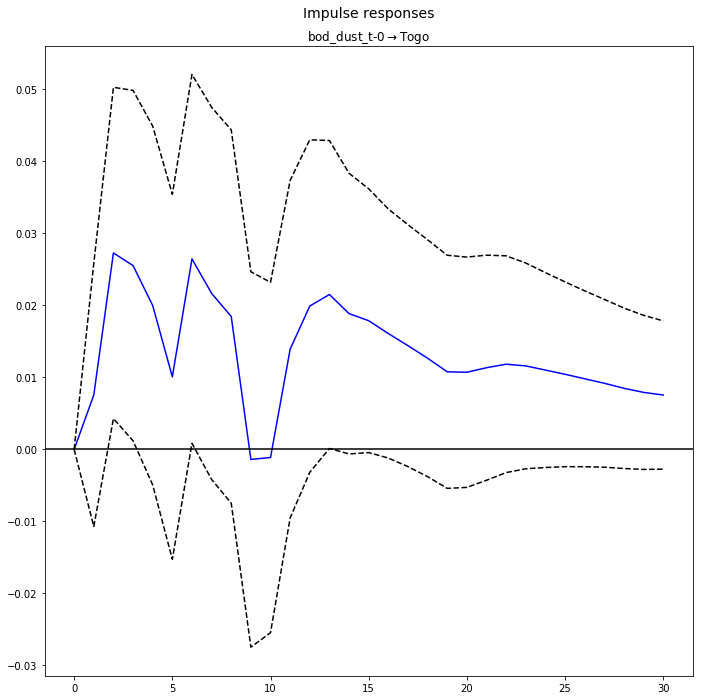

In [119]:
irf = results_t.irf(30)
irf.plot(orth=False, impulse = 'bod_dust_t-0', response='Togo')

In [114]:
irf

TypeError: 'IRAnalysis' object does not support indexing

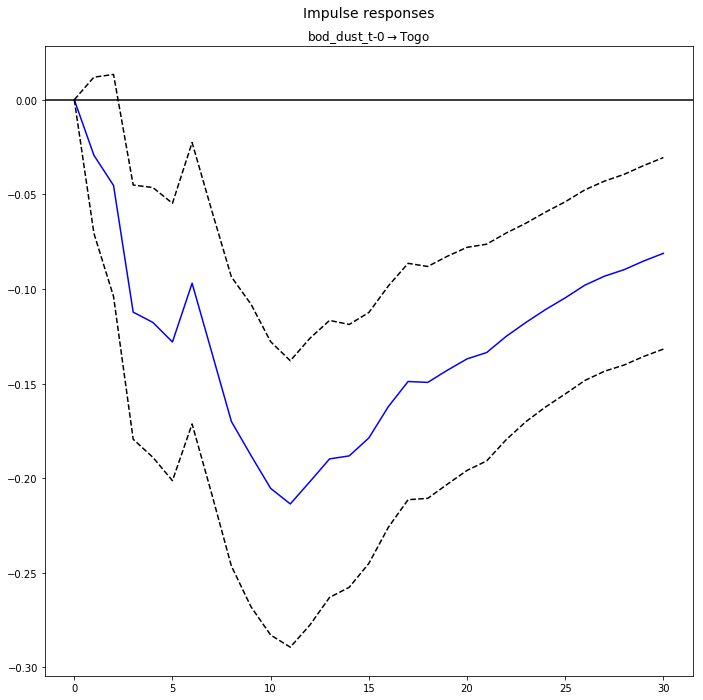

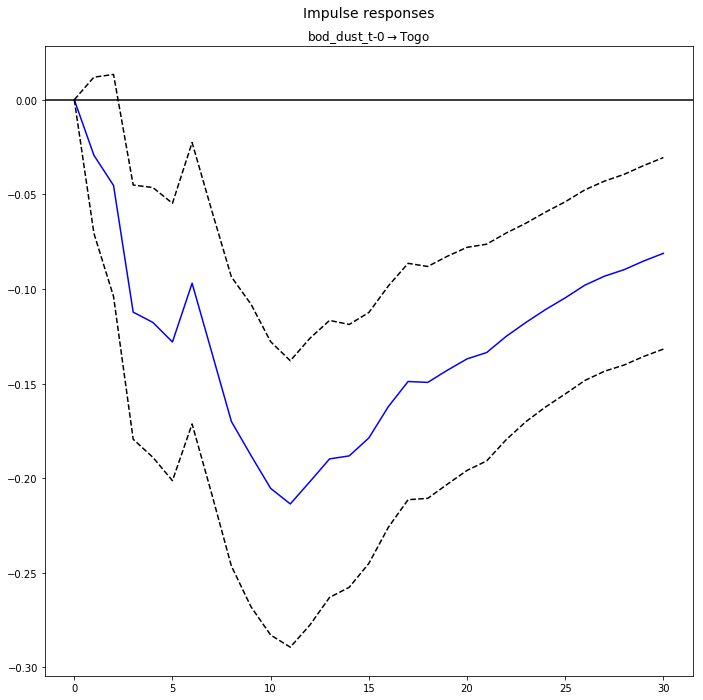

In [121]:
irf2 = results2.irf(30)
irf2.plot(orth=False, impulse = 'bod_dust_t-0', response='Togo')

In [72]:
model = sm.OLS(Y_array_df, X_array_df).fit()
predictions = model.predict(X_array_df) 

print_model = model.summary()
print(print_model)

model_95 = model.conf_int(alpha=0.05, cols=None)

                                 OLS Regression Results                                
Dep. Variable:         togo_coast_aod   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.755
Method:                 Least Squares   F-statistic:                              2780.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):                        0.00
Time:                        10:33:39   Log-Likelihood:                         -370.96
No. Observations:               13515   AIC:                                      771.9
Df Residuals:                   13500   BIC:                                      884.6
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [67]:

model = sm.OLS(daily_togo_coast_aod_data, x_array_rhs).fit()
predictions = model.predict(x_array_rhs) 

print_model = model.summary()
print(print_model)

model_95 = model.conf_int(alpha=0.05, cols=None)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.755
Method:                 Least Squares   F-statistic:                              2780.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):                        0.00
Time:                        10:26:05   Log-Likelihood:                         -370.96
No. Observations:               13515   AIC:                                      771.9
Df Residuals:                   13500   BIC:                                      884.6
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [68]:
print(model_95)

[[-3.29280496e-02 -7.62259776e-03]
 [ 3.08966488e-01  3.34876955e-01]
 [-1.35650629e-01 -5.55310973e-02]
 [-4.21146291e-02  7.62855356e-02]
 [-2.53739806e-02  9.88039335e-02]
 [ 9.36269017e-02  2.18710678e-01]
 [ 6.80217570e-03  1.31950533e-01]
 [ 1.63399289e-02  1.41554034e-01]
 [-6.72838604e-02  5.78631491e-02]
 [-3.75495199e-02  8.75229210e-02]
 [-8.68047265e-02  3.73999423e-02]
 [-3.03912464e-02  8.80841531e-02]
 [-8.29341477e-02 -2.42039529e-03]
 [-8.86808972e+02 -7.07663784e+02]
 [ 4.08483360e-04  5.52646066e-04]]


In [96]:
import numpy as np

import pandas

import statsmodels.api as sm

from statsmodels.tsa.api import VAR

mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

from statsmodels.tsa.base.datetools import dates_from_str

quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]

mdata.index = pandas.DatetimeIndex(quarterly)

data = np.log(mdata).diff().dropna()

# make a VAR model
model = VAR(data)

C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


In [113]:
X_array_novapr_pred_test

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [167]:
# X_array_novapr_df = pd.DataFrame(X_array_novapr, columns = ['bod_dust_t-10', 'bod_dust_t-9', 'bod_dust_t-8', 'bod_dust_t-7',
#                                                             'bod_dust_t-6', 'bod_dust_t-5', 'bod_dust_t-4', 'bod_dust_t-3',
#                                                             'bod_dust_t-2', 'bod_dust_t-1', 'bod_dust_t-0'])

X_array_novapr_df = pd.DataFrame(daily_bodele_mean_dust_novapr_data, columns = ['bod_dust_'])

 
# Using DataFrame.insert() to add a column
X_array_novapr_df.insert(0, "togo_dust", Y_array_novapr, True)
# X_array_novapr_df.insert(2, "foobar",0)


X_array_junsep_df = pd.DataFrame(daily_bodele_mean_dust_junsep_data, columns = ['bod_dust_'])

 
# Using DataFrame.insert() to add a column
X_array_junsep_df.insert(0, "togo_dust", Y_array_junsep, True)

# X_array_novapr_df.loc[~(X_array_novapr_df==0).any(axis=1)]

# X_array_novapr = np.zeros((6706, 11))

# for i in range(10,X_array_novapr.shape[0]):
#     X_array_novapr[i][10] = daily_bodele_mean_dust_novapr_data[i-10]    #mean dust over Bodélé Depression 10 days prior
#     X_array_novapr[i][9] = daily_bodele_mean_dust_novapr_data[i-9]      #mean dust over Bodélé Depression 9 days prior
#     X_array_novapr[i][8] = daily_bodele_mean_dust_novapr_data[i-8]      #mean dust over Bodélé Depression 8 days prior
#     X_array_novapr[i][7] = daily_bodele_mean_dust_novapr_data[i-7]      #mean dust over Bodélé Depression 7 days prior
#     X_array_novapr[i][6] = daily_bodele_mean_dust_novapr_data[i-6]      #mean dust over Bodélé Depression 6 days prior
#     X_array_novapr[i][5] = daily_bodele_mean_dust_novapr_data[i-5]      #mean dust over Bodélé Depression 5 days prior
#     X_array_novapr[i][4] = daily_bodele_mean_dust_novapr_data[i-4]      #mean dust over Bodélé Depression 4 days prior
#     X_array_novapr[i][3] = daily_bodele_mean_dust_novapr_data[i-3]      #mean dust over Bodélé Depression 3 days prior
#     X_array_novapr[i][2] = daily_bodele_mean_dust_novapr_data[i-2]      #mean dust over Bodélé Depression 2 days prior
#     X_array_novapr[i][1] = daily_bodele_mean_dust_novapr_data[i-1]      #mean dust over Bodélé Depression 1 day prior
#     X_array_novapr[i][0] = daily_bodele_mean_dust_novapr_data[i-0]      #mean dust over Bodélé Depression 0 days prior


In [168]:
X_array_novapr_df

X_array_novapr_df.to_csv('X_array_novapr_df.csv', index=False)

In [152]:
model = VAR(X_array_novapr_df)
model2 = VAR(X_array_junsep_df)

In [153]:
results = model.fit(10)

results.summary()

results2 = model2.fit(10)

results2.summary()

LinAlgError: 3-th leading minor of the array is not positive definite

In [162]:
import statsmodels.api as sm
import sklearn.metrics as skm
estVAR = sm.tsa.VAR(X_array_novapr_df).fit(10)
skm.r2_score(estVAR.fittedvalues['foobar']+estVAR.resid['foobar'],
  estVAR.fittedvalues['foobar'])

1.0

In [163]:
y = estVAR.fittedvalues['foobar']+estVAR.resid['foobar']
r_sq = 1 - np.sum(estVAR.resid['foobar'].values**2)/np.sum((y.values-y.mean())**2)

C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [164]:
print(r_sq)

nan


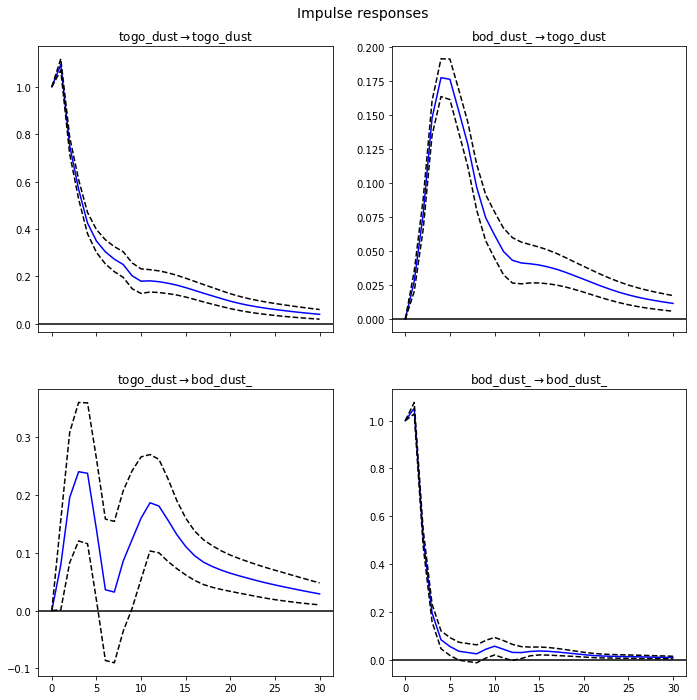

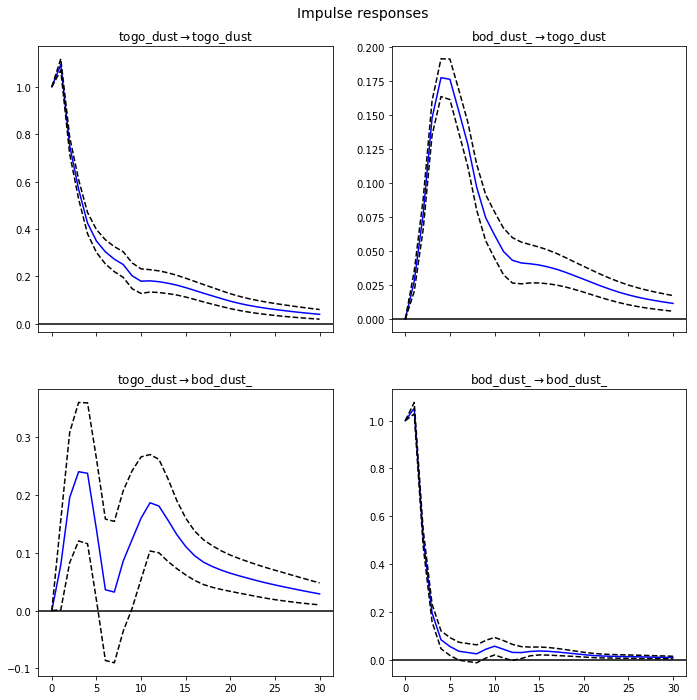

In [138]:
irf = results.irf(30)
irf.plot(orth=False)

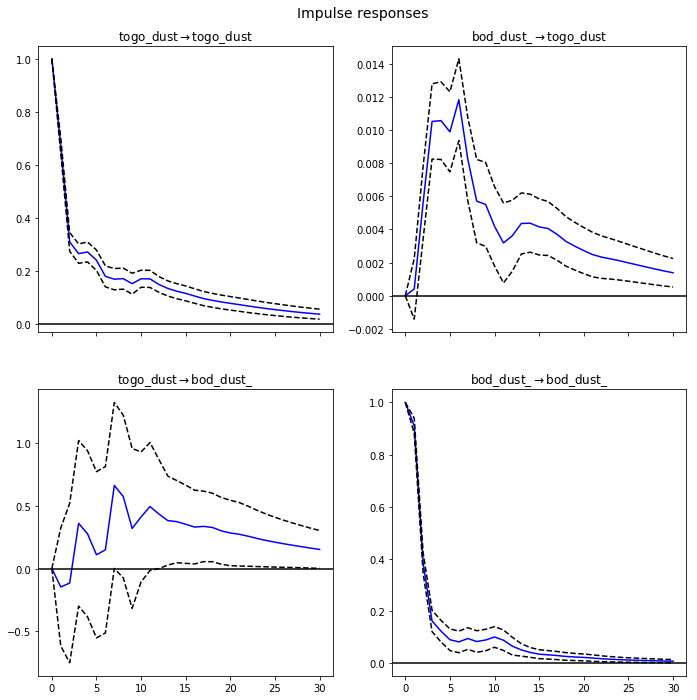

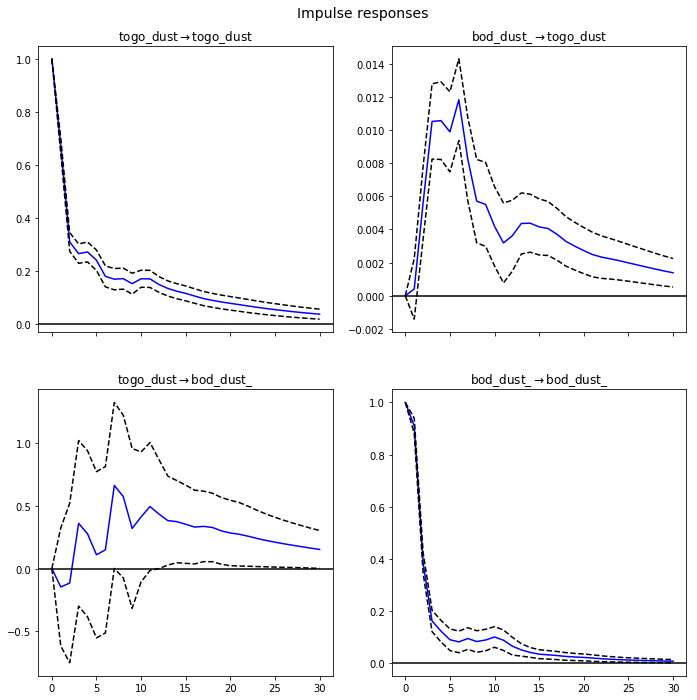

In [142]:
irf = results2.irf(30)
irf.plot(orth=False)